In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras=tf.keras

In [ ]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

(raw_train, raw_validation, raw_test), metadata= tfds.load('cats_vs_dogs', split=['train[:80%]','train[80%:90%]', 'train[90%:]'], with_info=True, as_supervised=True)

Dataset cats_vs_dogs downloaded and prepared to ~/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


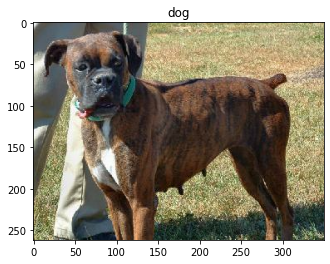

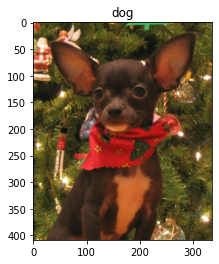

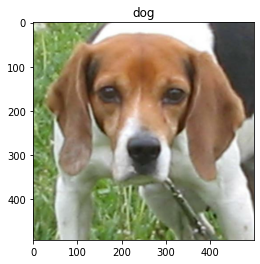

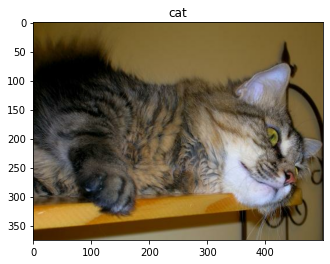

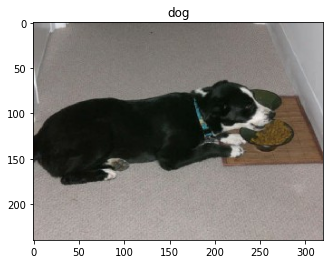

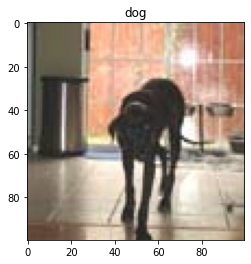

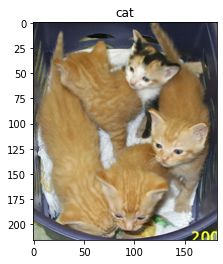

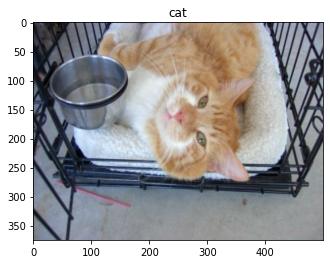

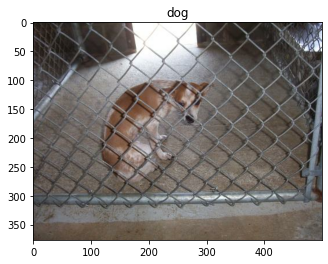

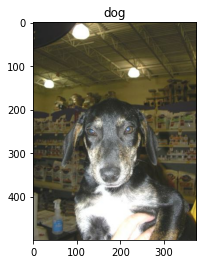

In [ ]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(10):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

In [ ]:
IMG_SIZE=200

def format_example(image,label):
    image=tf.cast(image, tf.float32)
    image = (image/127.5)- 1
    image = tf.image.resize(image,(IMG_SIZE, IMG_SIZE))
    return image, label


train= raw_train.map(format_example)
validation= raw_validation.map(format_example)
test= raw_test.map(format_example)

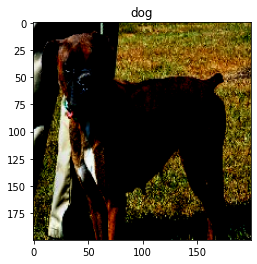

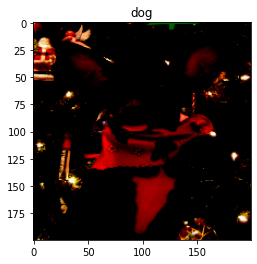

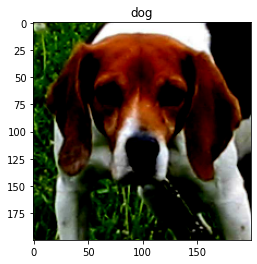

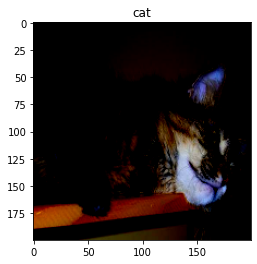

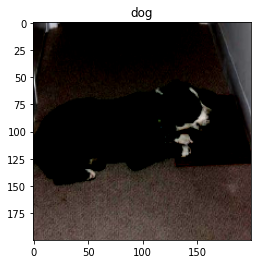

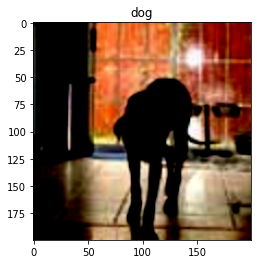

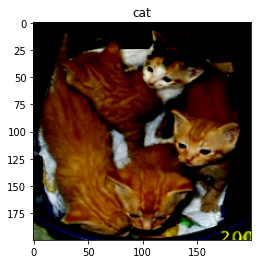

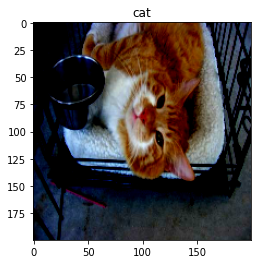

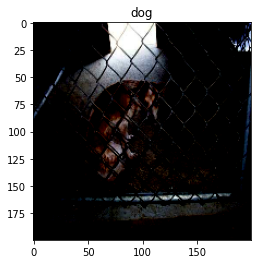

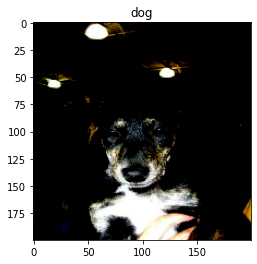

In [ ]:
for image, label in train.take(10):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

In [ ]:
BATCH_SIZE=40
SHUFFLE_BUFFER_SIZE=1000
train_batches= train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches= validation.batch(BATCH_SIZE)
test_batches= test.batch(BATCH_SIZE)

In [ ]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 100, 100, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 100, 100, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
base_model.trainable = False

In [ ]:
global_avg_layer= tf.keras.layers.GlobalAveragePooling2D()
pred_layer=keras.layers.Dense(1)


In [ ]:
model = tf.keras.Sequential([base_model, global_avg_layer, pred_layer])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
base_learn_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learn_rate), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
history= model.fit(train_batches, epochs=3 , validation_data=validation_batches)

Epoch 1/3
466/466 [==============================] - 499s 1s/step - loss: 0.2383 - accuracy: 0.8977 - val_loss: 0.0905 - val_accuracy: 0.9703
Epoch 2/3
466/466 [==============================] - 493s 1s/step - loss: 0.0713 - accuracy: 0.9788 - val_loss: 0.0621 - val_accuracy: 0.9764
Epoch 3/3
466/466 [==============================] - 500s 1s/step - loss: 0.0543 - accuracy: 0.9837 - val_loss: 0.0541 - val_accuracy: 0.9781


In [ ]:
model.save("dogs_vs_cats.h5")

In [ ]:
predictions= model.predict(test_batches)

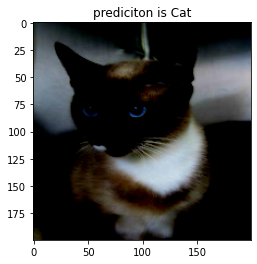

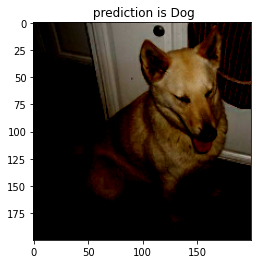

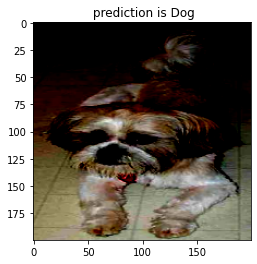

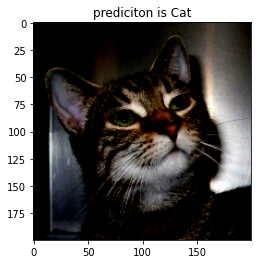

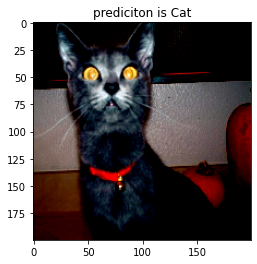

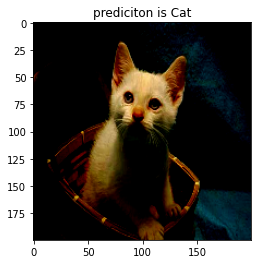

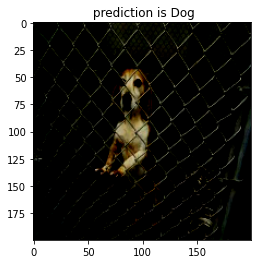

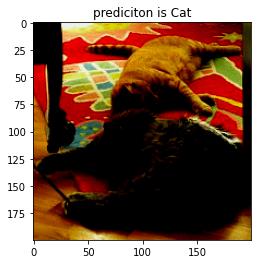

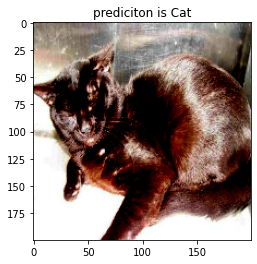

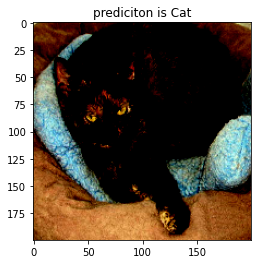

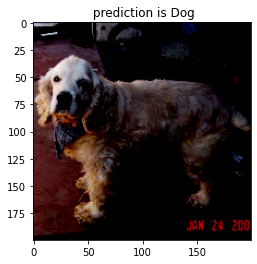

In [ ]:
i=0
for image, label in test.take(11):
    plt.figure()
    plt.imshow(image)
    if predictions[i]>0:
        plt.title(" prediction is Dog")
    elif predictions[i]<0:
        plt.title("prediciton is Cat")


    i+=1